<a href="https://colab.research.google.com/github/vu21csen0300061/EXPLORING_ML/blob/main/emailspam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences
# Padded Sequences: [    [3, 4, 1, 5, 2, 0], [6, 3, 4, 1, 7, 2],
#     [1, 8, 2, 4, 9, 0], [10, 1, 11, 2, 0, 0]
# ]
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
#checks the model working
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
data = pd.read_csv('/content/email.csv')
data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0.0
1,martin a posted tassos papadopoulos the greek ...,0.0
2,man threatens explosion in moscow thursday aug...,0.0
3,klez the virus that won t die already the most...,0.0
4,in adding cream to spaghetti carbonara which ...,0.0


In [3]:
data.shape

(3016, 2)

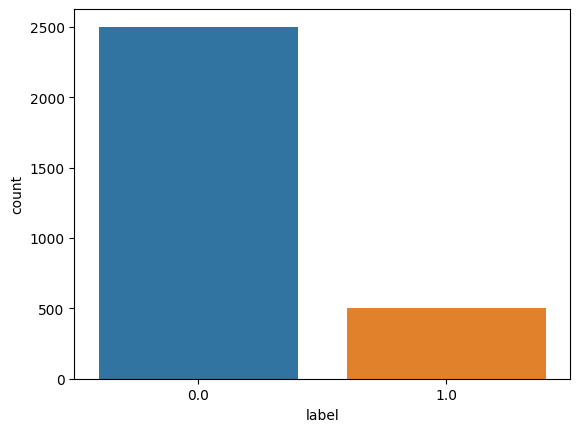

In [4]:
sns.countplot(x='label', data=data)
#plt.legend()
plt.show()

Text(0.5, 0, 'Message types')

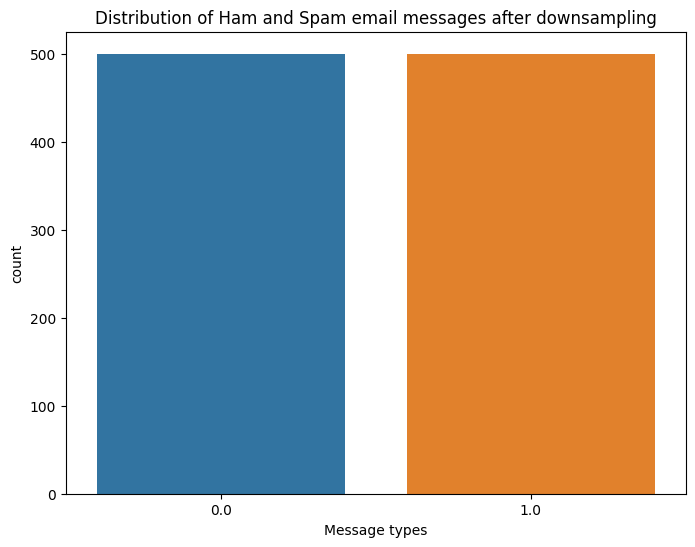

In [5]:
# Downsampling to balance the dataset
ham_msg = data[data.label== 0]
spam_msg = data[data.label == 1]
ham_msg = ham_msg.sample(n=len(spam_msg),
                        random_state=42)

balanced_data = ham_msg.append(spam_msg)\
    .reset_index(drop=True)
plt.figure(figsize=(8, 6))
sns.countplot(data = balanced_data, x='label')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')

In [6]:
balanced_data['email'] = balanced_data['email'].str.replace('Subject', '')
balanced_data.head()


,email,label
0,on fri sep NUMBER NUMBER at NUMBER NUMBER NUMB...,0.0
1,have you thought of bumping up sylpheed claws ...,0.0
2,title page has a login screen and i can t seem...,0.0
3,url URL date not supplied img URL wonderful ga...,0.0
4,URL spamassassin contrib URL changed what rem...,0.0


In [7]:
import string

punctuations_list = string.punctuation

def remove_punctuations(text):
    if isinstance(text, str):  # Check if 'text' is a string
        temp = str.maketrans('', '', punctuations_list)
        return text.translate(temp)
    else:
        return text

balanced_data['email'] = balanced_data['email'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,email,label
0,on fri sep NUMBER NUMBER at NUMBER NUMBER NUMB...,0.0
1,have you thought of bumping up sylpheed claws ...,0.0
2,title page has a login screen and i can t seem...,0.0
3,url URL date not supplied img URL wonderful ga...,0.0
4,URL spamassassin contrib URL changed what rem...,0.0


In [8]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []


    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output


balanced_data['email'] = balanced_data['email'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,email,label
0,fri sep number number number number numberam n...,0.0
1,thought bumping sylpheed claws see sylpheed go...,0.0
2,title page login screen seem get apt indexes a...,0.0
3,url url date supplied img url wonderful galler...,0.0
4,url spamassassin contrib url changed removed a...,0.0


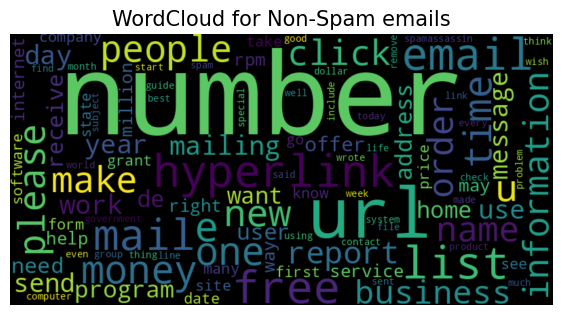

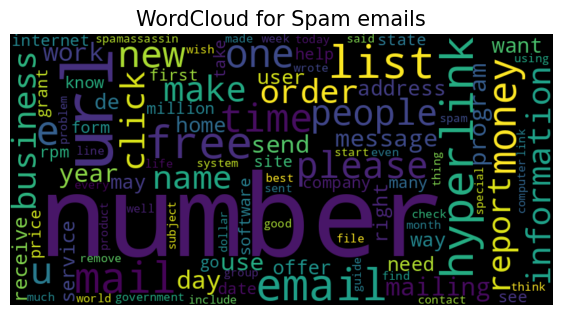

In [9]:
def plot_word_cloud(data, typ):
	email_corpus = " ".join(balanced_data['email'])

	plt.figure(figsize=(7, 7))

	wc = WordCloud(background_color='black',
				max_words=100,
				width=800,
				height=400,
				collocations=False).generate(email_corpus)

	plt.imshow(wc, interpolation='bilinear')
	plt.title(f'WordCloud for {typ} emails', fontsize=15)
	plt.axis('off')
	plt.show()

plot_word_cloud(balanced_data[balanced_data['label'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label'] == 1], typ='Spam')








In [10]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['email'],
													balanced_data['label'],
													test_size = 0.2,
													random_state = 42)


In [11]:
## Filter out non-text elements from train_X
train_X = [text for text in train_X if isinstance(text, str)]


tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)


train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)


max_len = 100  # maximum sequence length
train_sequences = pad_sequences(train_sequences,
                                maxlen=max_len,
                                padding='post',
                                truncating='post')
test_sequences = pad_sequences(test_sequences,
                               maxlen=max_len,
                               padding='post',
                               truncating='post')

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

# Build the model
model = keras.Sequential([
    layers.Input(shape=(max_len,)),  # Input layer for sequences of length 'max_len'
    layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32),
    layers.Flatten(),  # Flatten the embedded sequences
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           482464    
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense (Dense)               (None, 64)                204864    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 687393 (2.62 MB)
Trainable params: 687393 (2.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
			metrics = ['accuracy'],
			optimizer = 'adam')

# Train the model
history = model.fit(train_sequences, train_Y,
					validation_data=(test_sequences, test_Y),
					epochs=20,
					batch_size=32
				)


Epoch 1/20
25/25 [==============================] - 1s 21ms/step - loss: 0.6476 - accuracy: 0.6900 - val_loss: 0.6127 - val_accuracy: 0.7200
Epoch 2/20
25/25 [==============================] - 0s 13ms/step - loss: 0.3879 - accuracy: 0.9525 - val_loss: 0.3467 - val_accuracy: 0.9100
Epoch 3/20
25/25 [==============================] - 0s 14ms/step - loss: 0.0866 - accuracy: 0.9950 - val_loss: 0.1646 - val_accuracy: 0.9500
Epoch 4/20
25/25 [==============================] - 0s 12ms/step - loss: 0.0182 - accuracy: 0.9987 - val_loss: 0.1488 - val_accuracy: 0.9400
Epoch 5/20
25/25 [==============================] - 0s 13ms/step - loss: 0.0085 - accuracy: 0.9987 - val_loss: 0.1248 - val_accuracy: 0.9450
Epoch 6/20
25/25 [==============================] - 0s 12ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.1074 - val_accuracy: 0.9550
Epoch 7/20
25/25 [==============================] - 0s 13ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.1235 - val_accuracy: 0.9500
Epoch 8/20
25

In [14]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)


7/7 [==============================] - 0s 3ms/step - loss: 0.0974 - accuracy: 0.9550
Test Loss : 0.09742437303066254
Test Accuracy : 0.9549999833106995
